Import Libraries

In [1]:
import os
import gc
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import random
import torch
import torch.nn as nn
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
from matplotlib import pyplot as plt 
from tqdm import tqdm

Install space-bandits and import BanditAlgorithm class

In [2]:
!pip install space-bandits
from space_bandits import BanditAlgorithm
clear_output()

Mount Google Drive

In [ ]:
## plug in gdrive to load the data from gdrive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Import modified contextual_dataset

In [3]:
## path to the contextual_dataset_wu.py file
path = '/content/drive/MyDrive/Fellowship_Deep_and_Wide_Bandit/'
sys.path.append(path)

from contextual_dataset_wu import ContextualDataset

Load a subset of the dataset

In [4]:
## Load a subset of the dataset

p = 0.01  # Read 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
data_snippet = pd.read_csv(
         path+'data_snippet.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p ## skip rows unless randomly generated number < p
)

Set rewards

In [5]:
## Use label encoding for campaign_type
data_snippet["campaign_type"] = data_snippet["campaign_type"].astype('category')
data_snippet["campaign_type_cat"] = data_snippet["campaign_type"].cat.codes

## Set rewards
data_snippet['rewards'] = data_snippet['opened'] 
data_snippet['rewards'][data_snippet['unsub']==1] = -2
data_snippet['rewards'][data_snippet['opened']==0] = -0.8
data_snippet['rewards'] = data_snippet['rewards'] + data_snippet['rev_3dv2'] / 100.

clear_output()

Define Dataset

In [6]:
## Define Dataset for data snippet
class BanditTestDataset(Dataset):
    def __init__(self, data, user_col, context_col, rewards_col, action_col=None):
        super(BanditTestDataset, self).__init__()
        ## data - pandas dataframe
        ## user_col - user IDs column name
        ## action_col - action column name
        ## context_col - context column names
        ## rewards_col - reward column name
        self.user_ids = data[user_col]
        self.context = data[context_col]
        self.rewards = data[rewards_col]
        if action_col != None:
          self.actions = data[action_col]
        
    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        ## returns numpy arrays
        user_id = self.user_ids.iloc[index].values[0]
        context = self.context.iloc[index].values
        reward = self.rewards.iloc[index].values[0]
        reward_orig = reward ## copy the reward before changing it
        if action_col != None:
          action = self.actions.iloc[index].values[0]
        else:
          ## Randomly choose to send or not send email
          randnum = random.random() ## draw a random number between 0 and 1
          threshold = 0.5 ## e.g., if thresehold = 0.2, send email 80% of the time
          if randnum >= threshold:
            action = 1 ## send email if random number larger than threshold, get the associated reward
          else:
            action = 0 ## don't send email if random number smaller than threshold
            reward = reward * -1. ## Get opposite reward compared to send email

        return user_id, action, context, reward, reward_orig

Define dataloaders

In [7]:
## Split 80/20 into train and val. Create dataloaders.
## val not used in this version, just trying to run space-bandits at this point...

train, val = train_test_split(data_snippet, test_size=0.2)

user_col = ['riid']
context_col = ['retention_score','recency_score','frequency_score','campaign_type_cat']
rewards_col = ['rewards']
action_col = None

batch_size = 2048

train_dataset = BanditTestDataset(train, user_col, context_col, rewards_col, action_col=None)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
del train

val_dataset = BanditTestDataset(val, user_col, context_col, rewards_col, action_col=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
del val

In [8]:
num_actions = 2 ## Send email or not send
num_features = len(context_col)
num_users = data_snippet[user_col].nunique()[0]
print("Number of actions:", num_actions)
print("Number of features:", num_features)
print("Number of users:", num_users)

Number of actions: 2
Number of features: 4
Number of users: 57852


Model Classes

In [52]:
class Wide_Model(nn.Module):
    def __init__(self, embed_size=100, n_action=2, embed_dim=64):
        ## Learns expected reward for each action given User ID
        ## Uses embeddings to 'memorize' individual users
        ## embed_size - size of the dictionary of embeddings
        ## embed_dim -  size of each embedding vector
        ## n_action - number of possible actions
        super(Wide_Model, self).__init__()
        self.embed_size = embed_size
        self.n_action = n_action
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(self.embed_size, self.embed_dim)
        self.lr = nn.Linear(self.embed_dim, self.n_action)
    
    def forward(self, x):
        ## Input: user ID
        x = self.embedding(x)
        x = self.lr(x)
        return x.squeeze(axis=0)
    

class Deep_Model(nn.Module):
    def __init__(self, context_size=5, layer_sizes=[50], n_action=2):
        ## Learns expected reward for each action given context
        ## layer_sizes (list of integers): defines neural network architecture: n_layers = len(layer_sizes), 
        ## value is per-layer width. (default [50])
        super(Deep_Model, self).__init__()
        self.context_size = context_size
        self.layer_sizes = layer_sizes
        self.n_action = n_action

        self.layers = []
        self.build_model()
        self.activation = nn.ReLU()
        #self.activation = nn.Sigmoid()
    
    def build_layer(self, inp_dim, out_dim):
        """Builds a layer in deep model """

        layer = nn.modules.linear.Linear(inp_dim,out_dim)
        nn.init.uniform_(layer.weight)
        name = f'layer {len(self.layers)}'
        self.add_module(name, layer)
        return layer
  
    
    def build_model(self):
        """
        Defines the actual NN model with fully connected layers.
        """
        for i, layer in enumerate(self.layer_sizes):
            if i==0:
                inp_dim = self.context_size
            else:
                inp_dim = self.layer_sizes[i-1]
            out_dim = self.layer_sizes[i]
            new_layer = self.build_layer(inp_dim, out_dim)
            self.layers.append(new_layer)

        output_layer = self.build_layer(out_dim, self.n_action)
        self.layers.append(output_layer)

    def forward(self, x):
        """forward pass of the neural network"""
        ## Input: context
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers)-1:
                x = self.activation(x)
        return x.squeeze(axis=0)
    

class Wide_and_Deep_Model(nn.Module):
    def __init__(self, context_size=5, deep_layer_sizes=[50,100], n_action=2, 
                 embed_size=100, wide_embed_dim=64):
        super(Wide_and_Deep_Model, self).__init__()
        ## Combines the Wide model and Deep model
        self.n_action = n_action
        self.context_size = context_size
        self.deep_layer_sizes = deep_layer_sizes
        self.embed_size = embed_size
        self.wide_embed_dim = wide_embed_dim

        self.lr = nn.Linear(self.n_action*2+1, self.n_action)
        self.wide_model = Wide_Model(embed_size=self.embed_size, n_action=self.n_action, embed_dim=self.wide_embed_dim)
        self.deep_model = Deep_Model(context_size=self.context_size, layer_sizes=self.deep_layer_sizes, n_action=self.n_action)
    
    def forward(self, wide_input, deep_input, user_freq=1):

        x_wide = self.wide_model(wide_input)
        x_deep = self.deep_model(deep_input)

        ## Concatenate outputs from wide and deep model, give user_freq to model
        if len(x_wide.size()) == 1:
          user_freq = torch.tensor([user_freq])
          x = torch.cat((x_wide,x_deep,user_freq))
        elif len(x_wide.size()) > 1:
          user_freq = torch.tensor(user_freq)
          x = torch.cat((x_wide,x_deep,user_freq), dim=1)
        
        ## Make output length the same as n_action
        x = self.lr(x)

        return x.squeeze(-1)

Test the wide and deep model with BanditAlgorithm

In [71]:
class Test_Wide_Deep_Bandits(BanditAlgorithm):
    def __init__(
        self,
        num_actions,
        num_features,
        wide_embed_size=100, ## Size of embedding dictionary for the wide model
        wide_embed_dim=64, ## Dimension of embedding for the wide model
        update_freq_nn = 1, ## Frequency to update the model, default updates model for every data point
        num_epochs = 1, ## Number of steps to Train for each update
        model_type = 'wide_deep', ## model_type = 'wide', 'deep', or 'wide_deep'
        name='test_deep_bandits'):
      
        hparams = {
                    'num_actions':num_actions,
                    'context_dim':num_features,
                    'max_grad_norm':5.0,
        }

        ## Raise error if model_type is not one of the available models
        possible_models = ['deep','wide','wide_deep']
        if model_type not in possible_models:
          raise NameError('model_type must be "deep", "wide", or "wide_deep"')

        self.name = name
        self.model_type = model_type
        self.wide_embed_dim = wide_embed_dim
        self.wide_embed_size = wide_embed_size
        self.hparams = hparams

        ## Initialize model and optimizer depending on model_type
        if self.model_type == 'deep':
          self.deep_model = Deep_Model(context_size=self.hparams['context_dim'],
                                       n_action=self.hparams['num_actions'])
          self.optim = torch.optim.RMSprop(self.deep_model.parameters())

        if self.model_type == 'wide':
          self.wide_model = Wide_Model(embed_size=self.wide_embed_size, 
                                      n_action=self.hparams['num_actions'], 
                                      embed_dim=self.wide_embed_dim)
          self.optim = torch.optim.RMSprop(self.wide_model.parameters())
        

        if self.model_type == 'wide_deep':
          self.wide_deep_model = Wide_and_Deep_Model(context_size=self.hparams['context_dim'],
                                                    embed_size=self.wide_embed_size, 
                                                    n_action=self.hparams['num_actions'], 
                                                    wide_embed_dim=self.wide_embed_dim) 
          self.optim = torch.optim.RMSprop(self.wide_deep_model.parameters())
        
        self.loss = nn.modules.loss.MSELoss()

        self.t = 0
        self.update_freq_nn = update_freq_nn 
        self.num_epochs = num_epochs  
        self.data_h = ContextualDataset(self.hparams['context_dim'],
                                        self.hparams['num_actions'],
                                        intercept=False)
        
        ## Keep a dictionary of users that matches user's riid to indexes between 0 and num_users
        ## Initialize dicitonary with a "dummy user" that will be used for prediction when the user has never been seen
        self.user_dict = {0:0} 

        ## Dictionary of how many times a user has been seen by model
        self.user_freq = {0:0}

        ## Number of users seen by model
        self.current_user_size = 1

    def expected_values(self, user_id, context):

        if not torch.is_tensor(user_id):
          user_id = torch.tensor(user_id)

        context = torch.tensor(context).float()
        user_freq = self.lookup_one_user_freq(user_id)
        user_idx = self.lookup_one_user_idx(user_id)

        if self.model_type == 'deep':
          x = self.deep_model(context)
        if self.model_type == 'wide':
          x = self.wide_model(user_idx)
        if self.model_type == 'wide_deep':
          x = self.wide_deep_model(user_idx, context, user_freq=user_freq)
          #x = x[0:n_act]+x[n_act:n_act*2] ## Add the output from wide and deep model

        return x

    def action(self, user_id, context):
        ## Select an action based on expected values of reward
        if self.model_type == 'deep':
          vals = self.expected_values(user_id, context)  ## for deep model
        if self.model_type == 'wide':
          vals = self.expected_values(user_id, context)   ## for wide model
        if self.model_type == 'wide_deep':
          vals = self.expected_values(user_id, context)  ## for wide and deep model
        return np.argmax(vals.detach().numpy())
        
    def update(self, user_id, context, action, reward):
        """
        Args:
          user_id: Last User ID
          context: Last observed context.
          action: Last observed action.
          reward: Last observed reward.
        """
        
        if not torch.is_tensor(user_id):
          user_id = torch.tensor(user_id)

        self.t += 1
        self.data_h.add(user_id, context, action, reward)
        self.update_user_dict(user_id)

        if self.t % self.update_freq_nn == 0:
          self.train(self.data_h, self.num_epochs)
        
        
    def do_step(self, u, x, y, w, f, step):
        if self.model_type == 'deep':
          y_hat = self.deep_model.forward(x.float())
        if self.model_type == 'wide':
          y_hat = self.wide_model.forward(u)
        if self.model_type == 'wide_deep':
          y_hat = self.wide_deep_model(u,x.float(),user_freq=f)
          ## replicate y and w to compare with y_hat from wide_deep model
          #y = torch.cat((y,y), dim=1) 
          #w = torch.cat((w,w), dim=1) 
        
        y_hat *= w
        ls = self.loss(y_hat, y.float())
        ls.backward()

        clip = self.hparams['max_grad_norm']

        if self.model_type == 'deep':
          torch.nn.utils.clip_grad_norm_(self.deep_model.parameters(), clip)
        if self.model_type == 'wide':
          torch.nn.utils.clip_grad_norm_(self.wide_model.parameters(), clip)
        if self.model_type == 'wide_deep':
          torch.nn.utils.clip_grad_norm_(self.wide_deep_model.parameters(), clip)

        self.optim.step()
        self.optim.zero_grad()

    def train(self, data, num_steps):
        """Trains the network for num_steps, using the provided data.
        Args:
          data: ContextualDataset object that provides the data.
          num_steps: Number of minibatches to train the network for.
        Takes longer to get batch data and train model as the data size increase
        """
        #print("Training at time {} for {} steps...".format(self.t, num_steps))

        batch_size = 512
        
        data.scale_contexts() ## have to scale the data first if scaled=True in data.get_batch_with_weights()

        for step in range(num_steps):
            u, x, y, w = data.get_batch_with_weights(batch_size, scaled=True)
            f = self.lookup_user_freqs(u) ## Lookup user frequency (number of user interactions)
            u = self.lookup_user_idxs(u) ## Lookup user indexes

            ## Training at time step 1 will cause problem if scaled=True, 
            ## because standard deviation=0, and scaled_context will equal nan
            if self.t != 1:
              self.do_step(u, x, y, w, f, step)
        
    def lookup_one_user_idx(self, user_id):
      ## Returns one user index 
      user_id = user_id.tolist()
      if user_id not in self.user_dict.keys():
        user_index = 0
      else:
        user_index = self.user_dict[user_id]
      return torch.tensor(user_index)
    
    def lookup_one_user_freq(self, user_id):
      ## Returns the number of times this user occurs in the dataset
      if torch.is_tensor(user_id):
        user_id = user_id.tolist()
      if user_id not in self.user_freq.keys():
        user_freq = 0
      else:
        user_freq = self.user_freq[user_id]
      return user_freq

    def lookup_user_idxs(self, user_ids):
      ## Returns a list of user indexes for input to the wide network
      user_ids = user_ids.tolist()
      user_index = [self.user_dict[u] for u in user_ids]
      return torch.tensor(user_index)
    
    def lookup_user_freqs(self, user_ids):
      ## Returns a list of user freq for input to the wide network
      user_ids = user_ids.tolist()
      user_freq = [[self.lookup_one_user_freq(u)] for u in user_ids]
      return torch.tensor(user_freq)
    
    def update_user_dict(self, user_id):
      ## Create/update a lookup dictionary that matches user ID to a user index between 0 and num_users
      user_id = user_id.tolist()
      if user_id not in self.user_dict:
        self.user_dict.update({user_id:self.current_user_size})
        self.user_freq.update({user_id:1})
        self.current_user_size += 1
      elif user_id in self.user_freq:
        self.user_freq[user_id] += 1
              
    def save(self, path):
        """saves model to path"""
        with open(path, 'wb') as f:
            pickle.dump(self, f)

Initialize and train models

In [72]:
model_wide = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='wide', update_freq_nn = 100, num_epochs = 1)
model_deep = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='deep', update_freq_nn = 100, num_epochs = 1)
model_wide_deep = Test_Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='wide_deep', update_freq_nn = 100, num_epochs = 1)

In [73]:
%%time
tbar = tqdm(train_dataloader)
for item in tbar:
  for i in range(batch_size):
    try:
      user1 = item[0][i]
      action1 = item[1][i]
      context1 = item[2][i]
      reward1 = item[3][i]
    except:
      break
    
    model_wide.update(user1,context1,action1,reward1)
    model_deep.update(user1,context1,action1,reward1)
    model_wide_deep.update(user1,context1,action1,reward1)

clear_output()

CPU times: user 1min 18s, sys: 628 ms, total: 1min 19s
Wall time: 1min 19s


In [13]:
## Save models
#model_wide.save(path+'ds_model_wide.pkl')
#model_deep.save(path+'ds_model_deep.pkl')
#model_wide_deep.save(path+'ds_model_wide_deep.pkl')

In [ ]:
## Load existing models
#model_wide = load_model(path+'ds_model_wide.pkl')
#model_deep = load_model(path+'ds_model_deep.pkl')
#model_wide_deep = load_model(path+'ds_model_wide_deep.pkl')

Evaluate model

In [93]:
def evaluate_model(dataloader, df, model, n_actions = 2,
                   context_cols = ['retention_score','recency_score','frequency_score','campaign_type_cat'], 
                   user_id_col = ['riid'],
                   epsilon = 0.1):
  
  tbar = tqdm(dataloader)

  y_true = []
  y_pred = []

  num_correct = 0
  n_sample = 0

  model_reward = 0.
  optimal_reward = 0.

  cum_model_reward = []
  cum_optimal_reward = []

  ## Context means and std for scaling 
  context_means = df[context_col].mean().values
  context_std = df[context_col].std().values

  for item in tbar:
    for i in range(batch_size):
      try:
        user1 = item[0][i]
        action1 = item[1][i]
        context1 = item[2][i]
        context1_scaled = (context1 - context_means) / context_std ## Scale context for input 
        reward_1 = item[3][i]
        reward_o = item[4][i]
      except:
        break

      if reward_o >= 0.0:
        best_action = 1
      else:
        best_action = 0
        
      y_true.append(best_action)

      ## Get best action: REMEMBER TO SCALE CONTEXT!!!!
      model_action = model.action(user1,context1_scaled)

      ## epsilon-greedy, choose a random action if a randomly generated number is less than epsilon
      if random.random() < epsilon:
        model_action = np.random.randint(0, n_actions)
      
      if model_action == 1:
        model_reward += reward_o
      elif model_action == 0:
        model_reward += reward_o * -1.
      
      if best_action == 1:
        optimal_reward += reward_o
      elif best_action == 0:
        optimal_reward += reward_o * -1.
      
      cum_model_reward.append(model_reward.tolist())
      cum_optimal_reward.append(optimal_reward.tolist())
      
      if best_action == model_action:
        num_correct += 1

      n_sample += 1

      y_pred.append(model_action)

  clear_output()

  reward_percent = (model_reward / optimal_reward * 100.).tolist()
  regret = (optimal_reward - model_reward).tolist()
  accuracy = num_correct / n_sample * 100
  print(f"Accuracy of model = {accuracy:.2f}%") 
  print(f"Model received {reward_percent:.2f}% of the optimal reward")
  print(f"Regret = {regret:.0f}", )
  print("")

  cf_matrix = confusion_matrix(y_true,y_pred)


  group_names = ["Don't Send (T)","Send (F)","Don't Send (F)","Send (T)"]

  group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  #labels = ["True Don't Send","False Don't Send","False Send","True Send"]
  #labels = np.asarray(labels).reshape(2,2)
  ax = plt.axes()
  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, 
            fmt='', cmap='Blues',annot_kws={"fontsize":16}, ax = ax)
  ax.set_title('Confusion Matrix')
  plt.show()
  print("")

  fig, ax = plt.subplots()
  steps = np.array(range(len(cum_model_reward)))
  ax.scatter(steps, cum_model_reward, color='r', label='Model')
  ax.scatter(steps, cum_optimal_reward, color='b', label='Optimal')
  plt.title("Cumulative Rewards (Model vs. Optimal)")
  plt.xlabel("Steps")
  plt.ylabel("Rewards")
  ax.legend()
  plt.show()

Accuracy of model = 79.38%
Model received 60.75% of the optimal reward
Regret = 18244



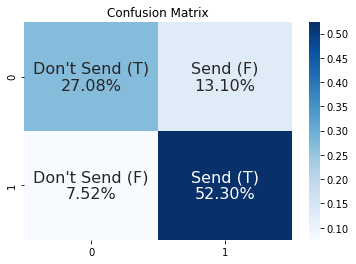

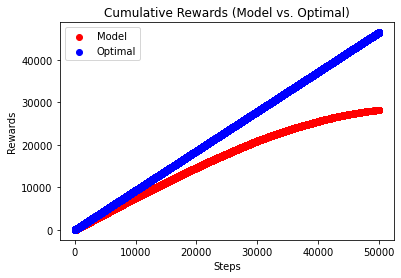

In [95]:
evaluate_model(train_dataloader, data_snippet, model_wide)

Accuracy of model = 75.11%
Model received 51.67% of the optimal reward
Regret = 22464



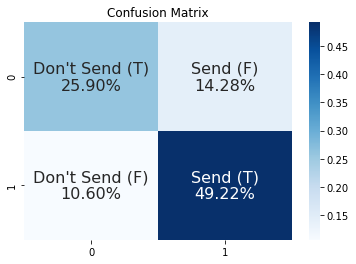

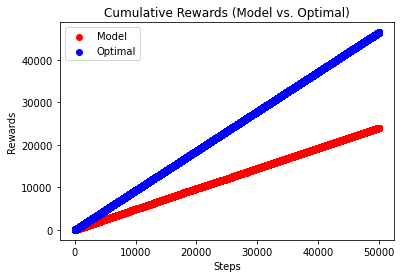

In [94]:
evaluate_model(train_dataloader, data_snippet, model_deep)

Accuracy of model = 83.37%
Model received 67.70% of the optimal reward
Regret = 15011



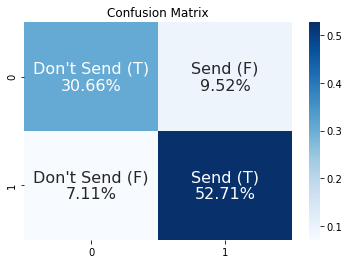

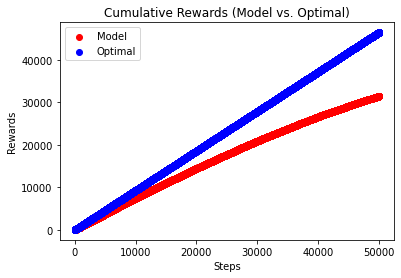

In [96]:
evaluate_model(train_dataloader, data_snippet, model_wide_deep)

Accuracy of model = 58.60%
Model received 25.39% of the optimal reward
Regret = 8668



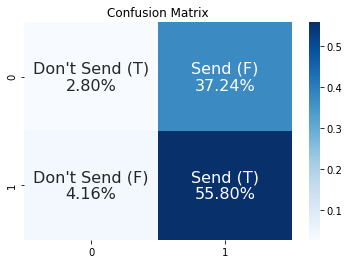

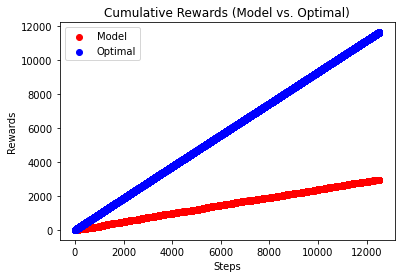

In [98]:
evaluate_model(val_dataloader, data_snippet, model_wide)

Accuracy of model = 75.29%
Model received 51.97% of the optimal reward
Regret = 5581



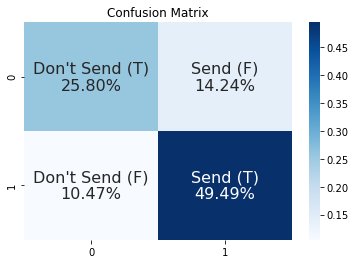

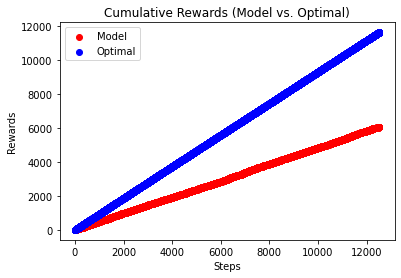

In [103]:
evaluate_model(val_dataloader, data_snippet, model_deep)

Accuracy of model = 74.44%
Model received 51.45% of the optimal reward
Regret = 5640



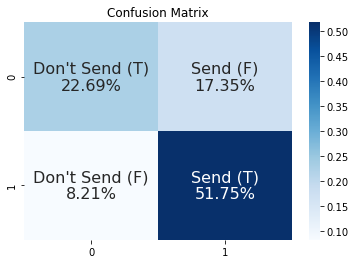

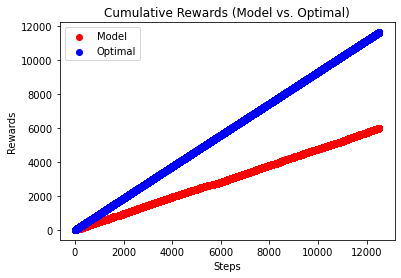

In [104]:
evaluate_model(val_dataloader, data_snippet, model_wide_deep)